In [25]:
import numpy as np
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


Just to make sure everything has been loaded in correctly, we can look at the dimensions of the vocabulary list and the embedding matrix. 

In [26]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


We can also search our word list for a word like "baseball", and then access its corresponding vector through the embedding matrix.

In [27]:
baseballIndex = wordsList.index('flower')
wordVectors[baseballIndex]

array([ 0.075439 ,  1.2659   , -1.3179   ,  0.11341  ,  1.4513   ,
        0.17337  , -0.56265  , -1.0706   ,  0.54898  ,  0.30163  ,
       -0.11471  ,  0.38498  ,  0.9205   , -0.2491   ,  0.3308   ,
        0.060113 , -0.0068846,  0.086864 , -0.20535  , -0.86098  ,
        0.10007  , -0.75486  ,  0.48225  , -0.33253  , -0.23791  ,
        0.17345  ,  0.49777  ,  0.88761  ,  0.089471 , -0.56217  ,
        1.8535   , -0.0055493,  0.45845  ,  0.53943  ,  0.3247   ,
        0.43479  , -0.027253 ,  0.44744  , -0.27514  , -0.016152 ,
       -0.51024  , -0.10113  , -0.80985  , -0.31571  ,  1.5817   ,
        0.2105   , -0.1844   , -1.7266   ,  0.092685 , -0.55696  ],
      dtype=float32)

Now that we have our vectors, our first step is taking an input sentence and then constructing the its vector representation. Let's say that we have the input sentence "I thought the movie was incredible and inspiring". In order to get the word vectors, we can use Tensorflow's embedding lookup function. This function takes in two arguments, one for the embedding matrix (the wordVectors matrix in our case), and one for the ids of each of the words. The ids vector can be thought of as the integerized representation of the training set. This is basically just the row index of each of the words. Let's look at a quick example to make this concrete. 

In [28]:
import tensorflow as tf
maxSeqLength = 10 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


The data pipeline can be illustrated below.

![caption](Images/SentimentAnalysis5.png)

The 10 x 50 output should contain the 50 dimensional word vectors for each of the 10 words in the sequence. 

In [29]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


Before creating the ids matrix for the whole training set, let’s first take some time to visualize the type of data that we have. This will help us determine the best value for setting our maximum sequence length. In the previous example, we used a max length of 10, but this value is largely dependent on the inputs you have.  

The training set we're going to use is the Imdb movie review dataset. This set has 25,000 movie reviews, with 12,500 positive reviews and 12,500 negative reviews. Each of the reviews is stored in a txt file that we need to parse through. The positive reviews are stored in one directory and the negative reviews are stored in another. The following piece of code will determine total and average number of words in each review. 

In [30]:
from os import listdir
from os.path import isfile, join
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 6000
The total number of words in the files is 1391142
The average number of words in the files is 231.857


We can also use the Matplot library to visualize this data in a histogram format. 

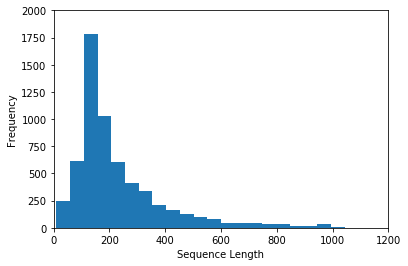

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 2000])
plt.show()

From the histogram as well as the average number of words per file, we can safely say that most reviews will fall under 250 words, which is the max sequence length value we will set. 

In [31]:
maxSeqLength = 250

Let's see how we can take a single file and transform it into our ids matrix. This is what one of the reviews looks like in text file format.

In [32]:
fname = positiveFiles[0] #Can use any valid index (not just 3)
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


Now, let's convert to to an ids matrix

In [33]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [34]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        if indexCounter < maxSeqLength:
            try:
                firstFile[indexCounter] = wordsList.index(word)
            except ValueError:
                firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([174943,    152,     14,      7,   7362,   2841,     20,   1421,
           22, 201534,    215,     79,     19,     77,     68,   1009,
           59,    164,    214,    125,     19,   2562,    192,   1678,
           82,      6, 201534,   3174,   8104,    410,    285,      4,
          733,     12, 174943,   7984,  15303,     14,    181,   2386,
            4,   2532,     73,     14,   2562, 201534,  14170,      4,
         3981,   7980, 201534,  34401,    543,     38,     86,    253,
          248,    131,     44,  22495,   2562,  31166, 201534,  91887,
            3, 201534,   1115,    794,     64,   9794,    285,      3,
       201534,    888,     41,   1522,      5,     44,    543,     61,
           41,    822, 201534,   1942,      6,     42,      7,   1283,
         2648,    977,      4,   6292,    135, 201534,    164,     41,
         1040,   3151,     22,    152,      7,   2392,    331,   5537,
        14663,    187,      4,  11739,     48,      3,    392,   2562,
      

Now, let's do the same for each of our 25,000 reviews. We'll load in the movie training set and integerize it to get a 25000 x 250 matrix. This was a computationally expensive process, so instead of having you run the whole piece, we’re going to load in a pre-computed IDs matrix.

In [12]:
# ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
# fileCounter = 0
# for pf in positiveFiles:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

# for nf in negativeFiles:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 
# #Pass into embedding function and see if it evaluates. 

# np.save('idsMatrix', ids)

In [35]:
ids = np.load('idsMatrix.npy')

# Helper Functions

Below you can find a couple of helper functions that will be useful when training the network in a later step. 

In [36]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(0,2700)
            labels.append([1,0])
        else:
            num = randint(3300,5999)
            labels.append([0,1])
        arr[i] = ids[num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(2700,3300)
        if (num <= 2999):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num]
    return arr, labels

# RNN Model

Now, we’re ready to start creating our Tensorflow graph. We’ll first need to define some hyperparameters, such as batch size, number of LSTM units, number of output classes, and number of training iterations. 

In [37]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 16000

As with most Tensorflow graphs, we’ll now need to specify two placeholders, one for the inputs into the network, and one for the labels. The most important part about defining these placeholders is understanding each of their dimensionalities. 

The labels placeholder represents a set of values, each either [1, 0] or [0, 1], depending on whether each training example is positive or negative. Each row in the integerized input placeholder represents the integerized representation of each training example that we include in our batch.

![caption](Images/SentimentAnalysis12.png)

In [38]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Once we have our input data placeholder, we’re going to call the tf.nn.lookup() function in order to get our word vectors. The call to that function will return a 3-D Tensor of dimensionality batch size by max sequence length by word vector dimensions. In order to visualize this 3-D tensor, you can simply think of each data point in the integerized input tensor as the corresponding D dimensional vector that it refers to. 


![caption](Images/SentimentAnalysis13.png)

In [39]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

Now that we have the data in the format that we want, let’s look at how we can feed this input into an LSTM network. We’re going to call the tf.nn.rnn_cell.BasicLSTMCell function. This function takes in an integer for the number of LSTM units that we want. This is one of the hyperparameters that will take some tuning to figure out the optimal value. We’ll then wrap that LSTM cell in a dropout layer to help prevent the network from overfitting. 

Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input data into a function called tf.nn.dynamic_rnn. This function is in charge of unrolling the whole network and creating a pathway for the data to flow through the RNN graph.

In [40]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

As a side note, another more advanced network architecture choice is to stack multiple LSTM cells on top of each other. This is where the final hidden state vector of the first LSTM feeds into the second. Stacking these cells is a great way to help the model retain more long term dependence information, but also introduces more parameters into the model, thus possibly increasing the training time, the need for additional training examples, and the chance of overfitting. For more information on how you can add stacked LSTMs to your model, check out Tensorflow's excellent [documentation](https://www.tensorflow.org/tutorials/recurrent#stacking_multiple_lstms).

The first output of the dynamic RNN function can be thought of as the last hidden state vector. This vector will be reshaped and then multiplied by a final weight matrix and a bias term to obtain the final output values.

In [41]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
#取最终的结果值
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

接下来，我们需要定义正确的预测函数和正确率评估参数。正确的预测形式是查看最后输出的0-1向量是否和标记的0-1向量相同。

In [42]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

We’ll define a standard cross entropy loss with a softmax layer put on top of the final prediction values. For the optimizer, we’ll use Adam and the default learning rate of .001. 

之后，我们使用一个标准的交叉熵损失函数来作为损失值。对于优化器，我们选择 Adam，并且采用默认的学习率。

In [43]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)


If you’d like to use Tensorboard to visualize the loss and accuracy values, you can also run and the modify the following code. 

In [44]:
import datetime

sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard4-7-1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Hyperparameter Tuning

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. You'll find that your training loss curves can vary with your choice of optimizer (Adam, Adadelta, SGD, etc), learning rate, and network architecture. With RNNs and LSTMs in particular, some other important factors include the number of LSTM units and the size of the word vectors.

* Learning Rate: RNNs are infamous for being diffult to train because of the large number of time steps they have. Learning rate becomes extremely important since we don't want our weight values to fluctuate wildly as a result of a large learning rate, nor do we want a slow training process due to a low learning rate. The default value of 0.001 is a good place to start. You should increase this value if the training loss is changing very slowly, and decrease if the loss is unstable.  
* Optimizer: There isn't a consensus choice among researchers, but Adam has been widely popular due to having the adaptive learning rate property (Keep in mind that optimal learning rates can differ with the choice of optimizer).
* Number of LSTM units: This value is largely dependent on the average length of your input texts. While a greater number of units provides more expressibility for the model and allows the model to store more information for longer texts, the network will take longer to train and will be computationally expensive. 
* Word Vector Size: Dimensions for word vectors generally range from 50 to 300. A larger size means that the vector is able to encapsulate more information about the word, but you should also expect a more computationally expensive model. 

# Training

The basic idea of the training loop is that we first define a Tensorflow session. Then, we load in a batch of reviews and their associated labels. Next, we call the session’s `run` function. This function has two arguments. The first is called the "fetches" argument. It defines the value we’re interested in computing. We want our optimizer to be computed since that is the component that minimizes our loss function. The second argument is where we input our `feed_dict`. This data structure is where we provide inputs to all of our placeholders. We need to feed our batch of reviews and our batch of labels. This loop is then repeated for a set number of training iterations.

Instead of training the network in this notebook (which will take at least a couple of hours), we’ll load in a pretrained model.

If you decide to train this notebook on your own machine, note that you can track its progress using [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). While the following cell is running, use your terminal to enter the directory that contains this notebook, enter `tensorboard --logdir=tensorboard`, and visit http://localhost:6006/ with a browser to keep an eye on your training progress.

In [45]:
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
# sess.run(tf.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();

    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
   #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)
        
    if (i%500==0):
        loss_ = sess.run(loss, {input_data: nextBatch, labels: nextBatchLabels})
        accuracy_=(sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100
        print("iteration:{}/{}".format(i+1, iterations),
                  "\nloss:{}".format(loss_),
                  "\naccuracy:{}".format(accuracy_))    
        print('..........')  

   #Save the network every 10,000 training iterations
    if (i % 1000 == 0 and i != 0):
        save_path = saver.save(sess, "models4-7-1/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()

iteration:1/16000 
loss:0.7575618624687195 
accuracy:50.0
..........
iteration:501/16000 
loss:0.7101984024047852 
accuracy:58.33333134651184
..........
iteration:1001/16000 
loss:0.6529808044433594 
accuracy:50.0
..........
saved to models4-7-1/pretrained_lstm.ckpt-1000
iteration:1501/16000 
loss:0.7020056247711182 
accuracy:62.5
..........
iteration:2001/16000 
loss:0.7107117176055908 
accuracy:50.0
..........
saved to models4-7-1/pretrained_lstm.ckpt-2000
iteration:2501/16000 
loss:0.5790966749191284 
accuracy:58.33333134651184
..........
iteration:3001/16000 
loss:0.7200605869293213 
accuracy:45.83333432674408
..........
saved to models4-7-1/pretrained_lstm.ckpt-3000
iteration:3501/16000 
loss:0.589256227016449 
accuracy:62.5
..........
iteration:4001/16000 
loss:0.5020411610603333 
accuracy:62.5
..........
saved to models4-7-1/pretrained_lstm.ckpt-4000
iteration:4501/16000 
loss:0.373099684715271 
accuracy:70.83333134651184
..........
iteration:5001/16000 
loss:0.38242673873901367

# Loading a Pretrained Model

Our pretrained model’s accuracy and loss curves during training can be found below. 

![caption](Images/SentimentAnalysis6.png)
![caption](Images/SentimentAnalysis7.png)

Looking at the training curves above, it seems that the model's training is going well. The loss is decreasing steadily, and the accuracy is approaching 100 percent. However, when analyzing training curves, we should also pay special attention to the possibility of our model overfitting the training dataset. Overfitting is a common phenomenon in machine learning where a model becomes so fit to the training data that it loses the ability to generalize to the test set. This means that training a network until you achieve 0 training loss might not be the best way to get an accurate model that performs well on data it has never seen before. Early stopping is an intuitive technique commonly used with LSTM networks to combat this issue. The basic idea is that we train the model on our training set, while also measuring its performance on the test set every now and again. Once the test error stops its steady decrease and begins to increase instead, you'll know to stop training, since this is a sign that the network has begun to overfit. 

Loading a pretrained model involves defining another Tensorflow session, creating a Saver object, and then using that object to call the restore function. This function takes into 2 arguments, one for the current session, and one for the name of the saved model. 

In [62]:
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
model_file=tf.train.latest_checkpoint('models4-7-1/')

saver.restore(sess, model_file)


INFO:tensorflow:Restoring parameters from models4-7-1/pretrained_lstm.ckpt-15000


In [58]:
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
model_file="models4-7-1/pretrained_lstm.ckpt-12000"
#model_file=tf.train.latest_checkpoint('models4-7-1/')

saver.restore(sess, model_file)

INFO:tensorflow:Restoring parameters from models4-7-1/pretrained_lstm.ckpt-12000


Then we’ll load some movie reviews from our test set. Remember, these are reviews that the model has not been trained on and has never seen before. The accuracy for each test batch can be seen when you run the following code. 

In [49]:
#14000
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 37.5
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 33.33333432674408
Accuracy for this batch: 50.0
Accuracy for this batch: 79.16666865348816
Accuracy for this batch: 50.0


In [51]:
#13000
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 37.5
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 62.5
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 50.0
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 62.5


In [53]:
#15000
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 37.5
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 70.83333134651184
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 50.0


# Conclusion

In this notebook, we went over a deep learning approach to sentiment analysis. We looked at the different components involved in the whole pipeline and then looked at the process of writing Tensorflow code to implement the model in practice. Finally, we trained and tested the model so that it is able to classify movie reviews.

With the help of Tensorflow, you can create your own sentiment classifiers to understand the large amounts of natural language in the world, and use the results to form actionable insights. Thanks for reading and following along!